In [1]:
local = False
tpu = True

In [2]:
if not local:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if local:
    file_path = '.'
else:
    file_path = 'drive/computer/trainer'

In [4]:
!pip install polars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import polars as pd

split_path = 'drive/Othercomputers/MacMini/split'

!ls drive/Othercomputers/MacMini/split

train_ts = pd.read_parquet(split_path + '/tdf_train.parquet')
train_md = pd.read_parquet(split_path + '/mdf_train.parquet')
train_y = pd.read_parquet(split_path + '/y_train.parquet')

val_ts = pd.read_parquet(split_path + '/tdf_val.parquet')
val_md = pd.read_parquet(split_path + '/mdf_val.parquet')
val_y = pd.read_parquet(split_path + '/y_val.parquet')

test_ts = pd.read_parquet(split_path + '/tdf_test.parquet')
test_md = pd.read_parquet(split_path + '/mdf_test.parquet')
test_y = pd.read_parquet(split_path + '/y_test.parquet')

mdf_test.parquet   tdf_test.parquet   y_test.parquet
mdf_train.parquet  tdf_train.parquet  y_train.parquet
mdf_val.parquet    tdf_val.parquet    y_val.parquet


In [6]:
# Remove auction_id from datapoints
import numpy as np

if isinstance(train_ts, pd.DataFrame):
    print(train_md.columns)
    columns_md = train_md.columns
    print(train_ts.columns)
    columns_ts = train_ts.columns
    print(train_y.columns)
    columns_y = train_y.columns

    train_ts = np.reshape(train_ts.to_numpy(), (-1, 9, 8))
    val_ts = np.reshape(val_ts.to_numpy(), (-1, 9, 8))
    test_ts = np.reshape(test_ts.to_numpy(), (-1, 9, 8))

    train_md = train_md.to_numpy()
    val_md = val_md.to_numpy()
    test_md = test_md.to_numpy()

    train_y = train_y.to_numpy().astype(int)
    val_y = val_y.to_numpy().astype(int)
    test_y = test_y.to_numpy().astype(int)

train_y.shape, val_y.shape, test_y.shape

['price', 'bin_price', 'no_jumper_limit', 'exchangeable', 'one_per_user', 'no_re_entry', 'is_bindolence', 'percent_off', 'start_hour_sin', 'start_hour_cos', 'start_minute_sin', 'start_minute_cos']
['prior_bid_dist_0', 'delta_0', 'avg_delta_0', 'std_delta_0', 'total_spend_0', 'avg_bid_price_0', 'std_bid_price_0', 'wins_0', 'prior_bid_dist_1', 'delta_1', 'avg_delta_1', 'std_delta_1', 'total_spend_1', 'avg_bid_price_1', 'std_bid_price_1', 'wins_1', 'prior_bid_dist_2', 'delta_2', 'avg_delta_2', 'std_delta_2', 'total_spend_2', 'avg_bid_price_2', 'std_bid_price_2', 'wins_2', 'prior_bid_dist_3', 'delta_3', 'avg_delta_3', 'std_delta_3', 'total_spend_3', 'avg_bid_price_3', 'std_bid_price_3', 'wins_3', 'prior_bid_dist_4', 'delta_4', 'avg_delta_4', 'std_delta_4', 'total_spend_4', 'avg_bid_price_4', 'std_bid_price_4', 'wins_4', 'prior_bid_dist_5', 'delta_5', 'avg_delta_5', 'std_delta_5', 'total_spend_5', 'avg_bid_price_5', 'std_bid_price_5', 'wins_5', 'prior_bid_dist_6', 'delta_6', 'avg_delta_6', 

((6140883, 1), (2030050, 1), (1688844, 1))

In [7]:
# weight the importance of each item by the buy-it-now price. We care more about more valuable items.
bin = train_md[:,1].reshape(-1)
bin_norm = (bin)/(np.max(bin))
train_sample_weights = bin_norm * 2
train_sample_weights

array([0.01772865, 0.01772865, 0.01772865, ..., 1.11523621, 1.11523621,
       1.11523621])

In [8]:
print("Pos examples:", np.sum(train_y))
train_y.shape

Pos examples: 4322


(6140883, 1)

In [9]:
print("total aucs count:", np.sum(train_y) + np.sum(val_y) + np.sum(train_y))

total aucs count: 10085


In [10]:
import tensorflow as tf

def create_model(classifier_neurons=128, lstm_neurons=128):
    nlp_input = tf.keras.layers.Input(shape=(train_ts.shape[1],train_ts.shape[2]), name='nlp_input')
    nlp_normalized = tf.keras.layers.BatchNormalization(axis=-1)(nlp_input)
    nlp_mid = tf.keras.layers.LSTM(lstm_neurons, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(nlp_normalized)
    nlp_out = tf.keras.layers.LSTM(lstm_neurons, dropout=0.2, recurrent_dropout=0.2)(nlp_mid)
    meta_input = tf.keras.layers.Input(shape=(train_md.shape[1],), name='meta_input')
    meta_normalized = tf.keras.layers.BatchNormalization(axis=-1)(meta_input)
    x = tf.keras.layers.concatenate([nlp_out, meta_normalized])
    x = tf.keras.layers.Dense(classifier_neurons, activation='relu')(x)
    x = tf.keras.layers.Dense(classifier_neurons, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=[nlp_input , meta_input], outputs=[x])

if tpu:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(resolver)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))

    strategy = tf.distribute.TPUStrategy(resolver)
    print("REPLICAS: ", strategy.num_replicas_in_sync)

    # Create model with TPU strategy
    with strategy.scope():
        model = create_model()
        model.compile(optimizer='adam',
                      # Anything between 2 and `steps_per_epoch` could help here.
                      steps_per_execution = 250,
                      loss='binary_crossentropy',
                      metrics=['binary_accuracy'])
else:
    model = create_model(classifier_neurons=32, lstm_neurons=64)
    model.compile(optimizer='adam',
                  # Anything between 2 and `steps_per_epoch` could help here.
                  steps_per_execution = 5,
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    
model.summary()

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
REPLICAS:  8
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 9, 8)]       0           []                    

In [11]:
filepath = "training/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [12]:
import numpy as np

class_weight = {}

class_weight[1] = np.size(train_y)/(2*np.count_nonzero(train_y == 1))
class_weight[0] = np.size(train_y)/(2*np.count_nonzero(train_y == 0))

print(class_weight)

{1: 710.4214484035169, 0: 0.5003521516367229}


In [13]:
history = model.fit([train_ts,train_md], 
                    train_y, 
                    batch_size=4096,
                    epochs=50, 
                    class_weight=class_weight,
                    #sample_weight=train_sample_weights,
                    callbacks=callbacks_list,
                    validation_data=([val_ts, val_md], 
                                     val_y))

Epoch 1/50
1500/1500 [==============================] - ETA: 0s - loss: 0.6129 - binary_accuracy: 0.6057
Epoch 1: loss improved from inf to 0.61287, saving model to training/weights-improvement-01-0.6129-bigger.hdf5
1500/1500 [==============================] - 54s 36ms/step - loss: 0.6129 - binary_accuracy: 0.6057 - val_loss: 0.5578 - val_binary_accuracy: 0.6921
Epoch 2/50
1500/1500 [==============================] - ETA: 0s - loss: 0.5407 - binary_accuracy: 0.6728
Epoch 2: loss improved from 0.61287 to 0.54070, saving model to training/weights-improvement-02-0.5407-bigger.hdf5
1500/1500 [==============================] - 17s 11ms/step - loss: 0.5407 - binary_accuracy: 0.6728 - val_loss: 0.5150 - val_binary_accuracy: 0.7022
Epoch 3/50
1500/1500 [==============================] - ETA: 0s - loss: 0.5047 - binary_accuracy: 0.7065
Epoch 3: loss improved from 0.54070 to 0.50469, saving model to training/weights-improvement-03-0.5047-bigger.hdf5
1500/1500 [==============================] - 1

In [14]:
model.save(file_path + '/models/tf/model-v1.h5')

In [15]:
import tensorflow as tf
if False:
    model = tf.keras.models.load_model(file_path + '/models/tf/model-no-weight-v1.h5')

In [16]:
val_pred = model.predict([val_ts, val_md])

63440/63440 [==============================] - 360s 6ms/step


In [22]:
# Not class weights
if False:
  print(np.random.choice(val_pred.reshape(-1), size=100, replace=False))

[4.14252281e-06 2.08616257e-07 2.60746479e-03 1.63298845e-03
 2.98023224e-08 2.80141830e-06 1.93715096e-06 0.00000000e+00
 2.02208757e-04 0.00000000e+00 5.61207533e-04 1.35296285e-02
 7.56084919e-05 4.60514426e-03 9.83476639e-07 0.00000000e+00
 2.08739936e-02 0.00000000e+00 2.98023224e-08 2.62260437e-06
 5.96582890e-04 7.74860382e-07 2.74181366e-06 2.98023224e-08
 1.89089775e-03 5.94854355e-05 6.88433647e-06 2.67624855e-04
 2.98023224e-08 1.19209290e-07 0.00000000e+00 2.98023224e-08
 2.86102295e-06 1.02800131e-03 0.00000000e+00 4.29153442e-06
 8.94069672e-08 0.00000000e+00 3.50534916e-04 5.69224358e-06
 0.00000000e+00 5.90980053e-05 1.40070915e-06 3.27825546e-07
 0.00000000e+00 2.98023224e-08 4.91797924e-03 1.60783529e-04
 6.91115856e-05 6.09219074e-04 2.06828117e-05 1.08927488e-04
 2.68220901e-06 0.00000000e+00 2.71201134e-06 0.00000000e+00
 1.31130219e-06 0.00000000e+00 3.20279598e-03 3.54647636e-04
 2.62260437e-06 0.00000000e+00 2.98023224e-08 5.39392233e-04
 4.76837158e-07 0.000000

In [20]:
# Class weights
if True:
  print(np.random.choice(val_pred.reshape(-1), size=10, replace=False))

[2.9802322e-07 9.9446177e-03 5.6928521e-01 2.8369540e-01 3.7372613e-01
 0.0000000e+00 7.6712167e-01 0.0000000e+00 5.9270108e-01 5.8710110e-01]


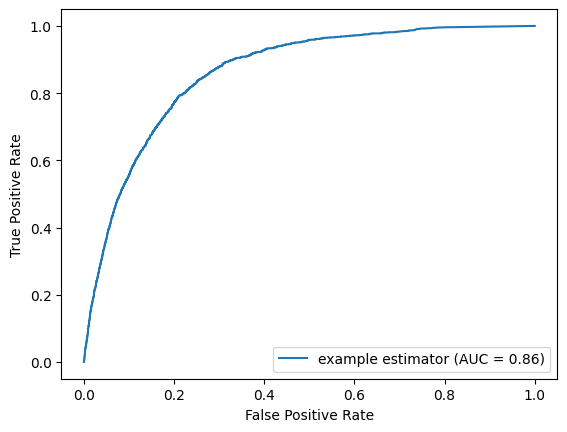

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(val_y, val_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()

plt.show()

In [ ]:
from imblearn import metrics
import sklearn

score = [0] * 100

for i in range(100):
    thresh = i/100
    score[i] = sklearn.metrics.f1_score(val_y.reshape(-1), (val_pred > thresh).reshape(-1))

max_score = score.index(max(score))
thresh = max_score / 100

(thresh, max(score))

(0.96, 0.013374135781480223)

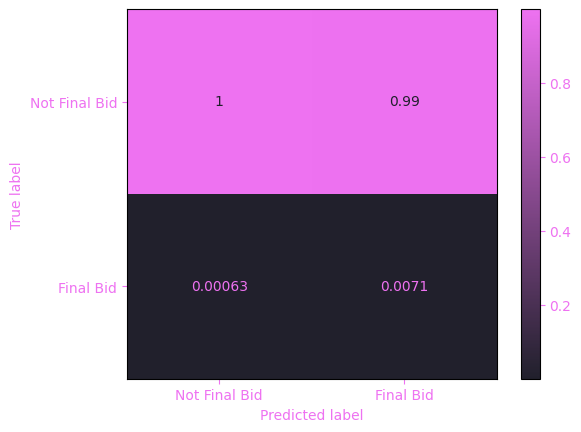

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.colors as color
import matplotlib as mpl

mpl.rcParams['text.color'] = "#ee72f1"
mpl.rcParams['axes.labelcolor'] = "#ee72f1"
mpl.rcParams['xtick.color'] = "#ee72f1"
mpl.rcParams['ytick.color'] = "#ee72f1"

cm = confusion_matrix(val_y, val_pred > thresh, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Final Bid', 'Final Bid'])
cmap = color.LinearSegmentedColormap.from_list("", ["#21202c","#ee72f1"])
disp.plot(cmap=cmap)

plt.savefig(file_path + '/models/tf/val_perf.png')
plt.show()

In [ ]:
res = confusion_matrix(val_y, val_pred > thresh)

f"Pred acc: {res[1][1] / (res[0][1] + res[1][1])} Got Percent: {res[1][1] / (res[1][0] + res[1][1])}"

'Pred acc: 0.007072079271216238 Got Percent: 0.12283136710617627'

In [ ]:
from imblearn import metrics
import sklearn

cms = [np.array([])] * 100
total_won = [0] * 100
total_paid = [0] * 100
total_missed = [0] * 100
total_missed_paid = [0] * 100

if columns_md[0] != 'price' or columns_md[1] != 'bin_price' or columns_md[7] != 'percent_off':
  print("Warning - results invalid, column layout changed")

for i in range(100):
    thresh = i/100
    cms[i] = confusion_matrix(val_y, val_pred > thresh)
    correctly_predicted = np.logical_and(val_y, val_pred > thresh).reshape(-1)
    total_won[i] = np.sum(val_md[correctly_predicted][:, 1])
    # Price paid (price * discount)
    total_paid[i] = np.sum(np.multiply(val_md[correctly_predicted][:, 0], (1 - val_md[correctly_predicted][:, 7] / 100)))

    missed = np.logical_and(np.logical_xor(val_y, val_pred > thresh), val_y).reshape(-1)
    total_missed[i] = np.sum(val_md[missed][:, 1])
    # Price paid (price * discount)
    total_missed_paid[i] = np.sum(np.multiply(val_md[missed][:, 0], (1 - val_md[missed][:, 7] / 100)))

cms = np.array(cms)

max_score = score.index(max(score))
thresh = max_score / 100

In [ ]:
np.array(cms).shape

(100, 2, 2)

In [ ]:
print("Total Won")
print(total_won)
print("Total Paid")
print(total_paid)
print("Total Price (missed)")
print(total_missed)
print("Total Paid (missed)")
print(total_missed_paid)
print("True positive")
print(cms[:,1:,1].reshape(-1))
print("False Negative")
print(cms[:,1:,0].reshape(-1))
print("False Positive")
print(cms[:,0:1,1].reshape(-1))
print("True Negative")
print(cms[:,0:1,0].reshape(-1))


Total Won
[59663900.0, 53167600.0, 52687300.0, 51836000.0, 51576300.0, 51012500.0, 50625500.0, 50405500.0, 50311400.0, 50007600.0, 49905900.0, 49753900.0, 49490800.0, 49450300.0, 49270200.0, 49003600.0, 48405300.0, 48114300.0, 47751900.0, 47572600.0, 46758900.0, 46733900.0, 46471900.0, 46362900.0, 45926100.0, 45819000.0, 45536200.0, 45025700.0, 44895200.0, 44652900.0, 44340900.0, 44257700.0, 44220600.0, 43552800.0, 43043500.0, 42738900.0, 42244200.0, 41836400.0, 41559500.0, 41109500.0, 40634000.0, 40593800.0, 40382900.0, 40085300.0, 40074300.0, 39945300.0, 39574800.0, 39534500.0, 39534500.0, 38542100.0, 37980500.0, 37364300.0, 36862900.0, 36827400.0, 36233400.0, 35932300.0, 35052800.0, 34918600.0, 34245500.0, 33858900.0, 33629900.0, 32929900.0, 32178400.0, 31785400.0, 31490700.0, 30781600.0, 30075900.0, 29622300.0, 29026700.0, 28546400.0, 27536000.0, 26807700.0, 26498300.0, 25973100.0, 25494200.0, 24543600.0, 24088000.0, 23154800.0, 22769100.0, 21755300.0, 20866300.0, 20182900.0, 19630

In [ ]:
test_pred = model.predict([test_ts, test_md])

52777/52777 [==============================] - 335s 6ms/step


In [ ]:
metrics.geometric_mean_score(test_y.reshape(-1), (test_pred > thresh).reshape(-1))

0.18809292837896877

In [ ]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(test_y, test_pred > thresh))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.04      1.00      0.19      0.04   1687404
          1       0.03      0.04      1.00      0.03      0.19      0.03      1440

avg / total       1.00      1.00      0.04      1.00      0.19      0.04   1688844



In [ ]:
res_test = confusion_matrix(test_y, test_pred > thresh)

f"Pred acc: {res_test[1][1] / (res_test[0][1] + res_test[1][1]):.2f} Got Percent: {res_test[1][1] / (res_test[1][0] + res_test[1][1]):.2f}"

'Pred acc: 0.03 Got Percent: 0.04'

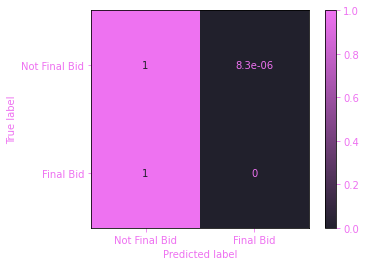

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.colors as color
import matplotlib as mpl

mpl.rcParams['text.color'] = "#ee72f1"
mpl.rcParams['axes.labelcolor'] = "#ee72f1"
mpl.rcParams['xtick.color'] = "#ee72f1"
mpl.rcParams['ytick.color'] = "#ee72f1"

cm = confusion_matrix(test_y, test_pred > thresh, normalize='true')#, labels=['Final Bid', 'Not Final Bid'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Final Bid', 'Final Bid'])
cmap = color.LinearSegmentedColormap.from_list("", ["#21202c","#ee72f1"])
disp.plot(cmap=cmap)

plt.savefig(file_path + '/models/tf/test_perf.png')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

matrices = []

for ithresh in range(1,100):
    matrices.append(confusion_matrix(val_y, val_pred > ithresh/100).flatten())

pd.DataFrame(matrices, columns=['TN','FP','FN','TP']).to_csv(file_path + "/models/tf/confusion.csv", index=None)